In [1]:
from __future__ import division
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json

from sklearn.cross_validation import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier as RF
%matplotlib inline 

In [2]:
from sklearn.cross_validation import KFold

def run_cv(X,y,scale, clf_class,**kwargs):
    #scale if asked
    if(scale):
        scaler = StandardScaler()
        X = scaler.fit_transform(X)
        
    # Construct a kfolds object
    kf = KFold(len(y),n_folds=3,shuffle=True)
    y_pred = y.copy()
    
    # Iterate through folds
    for train_index, test_index in kf:
        X_train, X_test = X[train_index], X[test_index]
        y_train = y[train_index]
        # Initialize a classifier with key word arguments
        clf = clf_class(**kwargs)
        clf.fit(X_train,y_train)
        y_pred[test_index] = clf.predict(X_test)
    return y_pred

## Model comparison

In [8]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier as RF
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.linear_model import LogisticRegression as LR
from sklearn.ensemble import GradientBoostingClassifier as GBC
from sklearn.metrics import average_precision_score

def compareAlgorithms(X,y):
    def accuracy(y_true,y_pred):
        # NumPy interpretes True and False as 1. and 0.
        return np.mean(y_true == y_pred)

    print "with | without scale"
    print "Logistic Regression:"
    print "%.3f | %.3f" % (accuracy(y, run_cv(X,y,0, LR)), accuracy(y, run_cv(X,y,1, LR))) 
    print "Gradient Boosting Classifier"
    print "%.3f | %.3f" % (accuracy(y, run_cv(X,y,0, GBC)), accuracy(y, run_cv(X,y,1, GBC))) 
    print "Support vector machines:"
    print "%.3f | %.3f" % (accuracy(y, run_cv(X,y,0, SVC)), accuracy(y, run_cv(X,y,1, SVC))) 
    print "Random forest:"
    print "%.3f | %.3f" % (accuracy(y, run_cv(X,y,0, RF)), accuracy(y, run_cv(X,y,1, RF))) 
    print "K-nearest-neighbors:"
    print "%.3f | %.3f" % (accuracy(y, run_cv(X,y,0, KNN)), accuracy(y, run_cv(X,y,1, KNN))) 

## ROC Plots and AUC
Simply put, the area under the curve (AUC) of a receiver operating characteristic (ROC) curve is a way to reduce ROC performance to a single value representing expected performance. To explain with a little more detail, a ROC curve plots the true positives (sensitivity) vs. false positives (1 − specificity), for a binary classifier system as its discrimination threshold is varied. Since a random method describes a horizontal curve through the unit interval, it has an AUC of .5. Minimally, classifiers should perform better than this, and the extent to which they score higher than one another (meaning the area under the ROC curve is larger), they have better expected performance.

In [55]:
from sklearn.metrics import roc_curve, auc
from scipy import interp

def plot_roc(X, y, clf_class, **kwargs):
    kf = KFold(len(y), n_folds=3, shuffle=True)
    y_prob = np.zeros((len(y),2))
    mean_tpr = 0.0
    mean_fpr = np.linspace(0, 1, 100)
    all_tpr = []
    for i, (train_index, test_index) in enumerate(kf):
        X_train, X_test = X[train_index], X[test_index]
        y_train = y[train_index]
        clf = clf_class(**kwargs)
        clf.fit(X_train,y_train)
        # Predict probabilities, not classes
        y_prob[test_index] = clf.predict_proba(X_test)
        fpr, tpr, thresholds = roc_curve(y[test_index], y_prob[test_index, 1])
        mean_tpr += interp(mean_fpr, fpr, tpr)
        mean_tpr[0] = 0.0
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=1, label='ROC fold %d (area = %0.2f)' % (i, roc_auc))
    mean_tpr /= len(kf)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    plt.plot(mean_fpr, mean_tpr, 'k--',label='Mean ROC (area = %0.2f)' % mean_auc, lw=2)
    
    plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Random')
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()
    
def plot_all_roc(X,y):
    print "Support vector machines:"
    plot_roc(X,y,SVC,probability=True)
    
    print "Random forests:"
    plot_roc(X,y,RF,n_estimators=18)
    
    print "K-nearest-neighbors:"
    plot_roc(X,y,KNN)
    
    print "Gradient Boosting Classifier:"
    plot_roc(X,y,GBC)



## Feature Importance
Now that we understand the accuracy of each individual model for our particular dataset, let's dive a little deeper to get a better understanding of what features or behaviours are causing our customers to churn. In the next section, we will be using a RandomForestClassifer to build an ensemble of decision trees to predict whether a customer will churn or not churn. One of the first steps in building a decision tree to calculating the information gain associated with splitting on a particular feature. (More on this later.)

In [84]:
# X df
# y should only contains boolean values
def feature_importance(X,y):
    X_train, X_test, y_train, y_test = train_test_split(X, y)
    nb_features=len(X.columns)
    
    forest = RF()
    forest_fit = forest.fit(X_train, y_train )
    forest_predictions = forest_fit.predict(X_test)

    importances = forest_fit.feature_importances_[:nb_features]
    std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
    indices = np.argsort(importances)[::-1]

    # Print the feature ranking
    print("Feature ranking:")

    for f in range(nb_features):
        print("%d. %s (%f)" % (f + 1, X.columns[f], importances[indices[f]]))

    # Plot the feature importances of the forest
    #import pylab as pl
    plt.figure()
    plt.title("Feature importances")
    plt.bar(range(nb_features), importances[indices], yerr=std[indices], color="r", align="center")
    plt.xticks(range(nb_features), indices)
    plt.xlim([-1, nb_features])
    plt.show()


# Load iris dataset
let's compare algorithms 

Feature ranking:
1. sepal length (cm) (0.535834)
2. sepal width (cm) (0.400000)
3. petal length (cm) (0.064166)
4. petal width (cm) (0.000000)


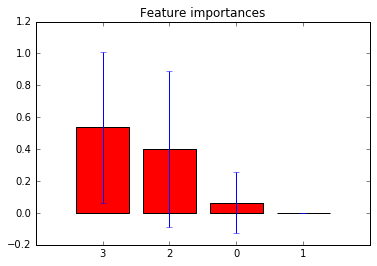

Support vector machines:


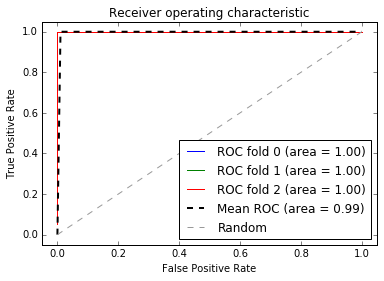

Random forests:


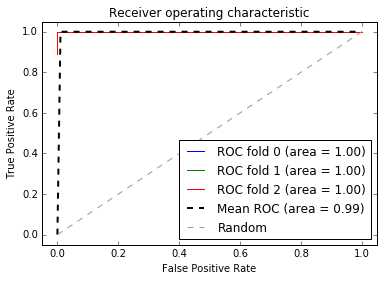

K-nearest-neighbors:


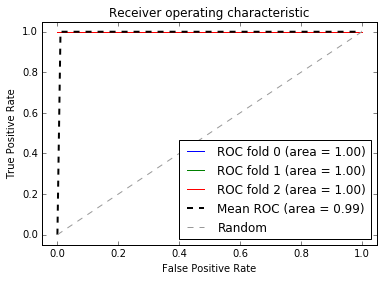

Gradient Boosting Classifier:


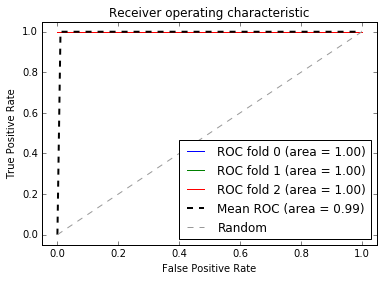

In [85]:
#iris dataset
from sklearn.datasets import load_iris
d_iris = load_iris()
data_df = pd.DataFrame(data=d_iris.data, columns= d_iris.feature_names)
target_df = pd.DataFrame(data=d_iris.target, columns=['specie'])

#iris_df = pd.concat([data_df, target_df], axis=1)
#print iris_df.columns.tolist()
#print iris_df.head(3)

#transform iris df back to numpy array
X = data_df.values.astype(np.float)
y = d_iris.target

#compareAlgorithms(X,y)

# for binary classificassion
isSetosa_df = target_df.applymap(lambda a: a==0)
y_bool = isSetosa_df.values.T.reshape(target_df.shape[0])
feature_importance(data_df,y_bool)
plot_all_roc(X,y_bool)

